torch version: 2.0.0
diffusers version: 0.16.1
device: mps


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

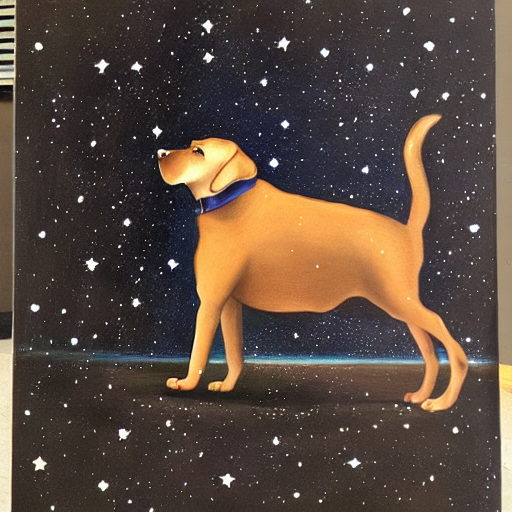

In [6]:
import torch
import diffusers 
from diffusers import StableDiffusionPipeline, StableDiffusionInstructPix2PixPipeline, DPMSolverMultistepScheduler
from safetensors.torch import load_file, save_file
from collections import defaultdict
import PIL

print("torch version:", torch.__version__)
print("diffusers version:", diffusers.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("device:", device)
seed = 1234567
generator = torch.manual_seed(seed)

# load diffusers model
txt2img_id = "runwayml/stable-diffusion-v1-5"
pipe_txt2img = StableDiffusionPipeline.from_pretrained(txt2img_id, torch_dtype=torch.float32)
pipe_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(pipe_txt2img.scheduler.config)
pipe_txt2img.to(device)

prompt = "A beautiful painting of a dog watching a deep space galaxy"
default_image = pipe_txt2img(prompt, num_inference_steps=20, guidance_scale=7.5, generator=generator).images[0]
default_image


In [8]:
def load_lora_weights(pipeline, checkpoint_path, multiplier, device, dtype):
    LORA_PREFIX_UNET = "lora_unet"
    LORA_PREFIX_TEXT_ENCODER = "lora_te"
    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path, device=device)

    updates = defaultdict(dict)
    for key, value in state_dict.items():
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        layer, elem = key.split('.', 1)
        updates[layer][elem] = value

    # directly update weight in diffusers model
    for layer, elems in updates.items():

        if "text" in layer:
            layer_infos = layer.split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = layer.split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        # get elements for this layer
        weight_up = elems['lora_up.weight'].to(dtype)
        weight_down = elems['lora_down.weight'].to(dtype)
        alpha = elems['alpha']
        if alpha:
            alpha = alpha.item() / weight_up.shape[1]
        else:
            alpha = 1.0

        # update weight
        if len(weight_up.shape) == 4:
            curr_layer.weight.data += multiplier * alpha * torch.mm(weight_up.squeeze(3).squeeze(2), weight_down.squeeze(3).squeeze(2)).unsqueeze(2).unsqueeze(3)
        else:
            curr_layer.weight.data += multiplier * alpha * torch.mm(weight_up, weight_down)

    return pipeline

In [12]:
# load lora weight
lora_path_detail = "../models/SD-LORA-Weights/add_detail.safetensors"
pipe_lora = load_lora_weights(pipe_txt2img, lora_path_detail, 1.0, "mps", torch.float32)
pipe_lora.to(device)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

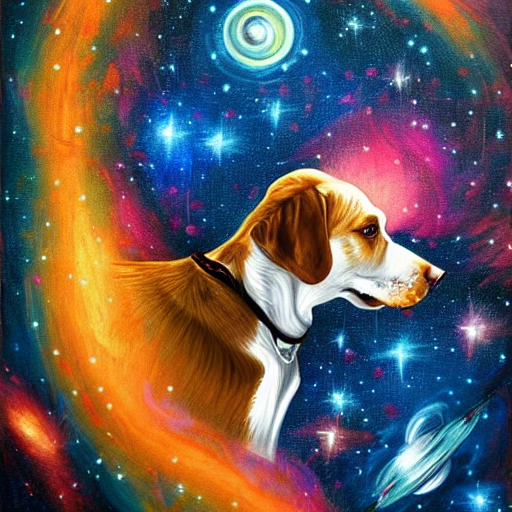

In [13]:
pipe_lora(prompt, num_inference_steps=20, guidance_scale=7.5, generator=generator).images[0]

IT WORKS. BEAUTIFUL. NOW LET's see if we can skip prompt-to-prompt buggy custom codes and just use instruct pix2pix or not.
I will literally just copy this notebook since it's very clean and just change model id

---

In [14]:
# load lora weight
lora_path_detail = "../models/SD-LORA-Weights/milkyW.safetensors"
pipe_lora = load_lora_weights(pipe_txt2img, lora_path_detail, 1.0, "mps", torch.float32)
pipe_lora.to(device)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

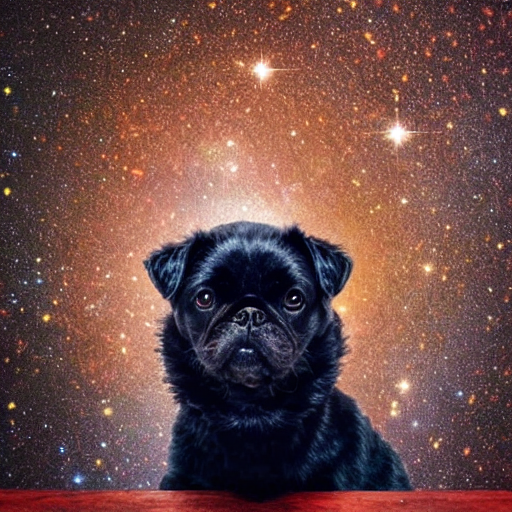

In [15]:
pipe_lora(prompt, num_inference_steps=20, guidance_scale=7.5, generator=generator).images[0]